### Imports

In [20]:
# Standard imports
import collections
from dataclasses import dataclass
import gdown
import os
import numpy as np
import math
import torch
from torch import Tensor
import torch.nn as nn
from tqdm.auto import tqdm
from typing import List, Literal, Sequence, Tuple, Union

# Imports for diffusion policy
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

# Imports for the Push-T environment
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
import jupyviz as jviz

# always call this first
from streaming_flow_policy.all import set_random_seed
set_random_seed(0)

### Environments


In [21]:
from typing import List, Dict, Optional
import numpy as np
import gym
from gym.spaces import Box
from robomimic.envs.env_robosuite import EnvRobosuite

class RobomimicLowdimWrapper(gym.Env):
    def __init__(self, 
        env: EnvRobosuite,
        obs_keys: List[str]=[
            'object', 
            'robot0_eef_pos', 
            'robot0_eef_quat', 
            'robot0_gripper_qpos'],
        init_state: Optional[np.ndarray]=None,
        render_hw=(256,256),
        render_camera_name='agentview'
        ):

        self.env = env
        self.obs_keys = obs_keys
        self.init_state = init_state
        self.render_hw = render_hw
        self.render_camera_name = render_camera_name
        self.seed_state_map = dict()
        self._seed = None
        
        # setup spaces
        low = np.full(env.action_dimension, fill_value=-1)
        high = np.full(env.action_dimension, fill_value=1)
        self.action_space = Box(
            low=low,
            high=high,
            shape=low.shape,
            dtype=low.dtype
        )
        obs_example = self.get_observation()
        low = np.full_like(obs_example, fill_value=-1)
        high = np.full_like(obs_example, fill_value=1)
        self.observation_space = Box(
            low=low,
            high=high,
            shape=low.shape,
            dtype=low.dtype
        )
    # [新增] 添加这个属性，方便外部直接访问 wrapper.sim
    @property
    def sim(self):
        # robomimic 的 EnvRobosuite 把原始环境存在了 .env 属性里
        # 所以我们需要穿透两层: wrapper.env -> EnvRobosuite.env -> RobosuiteRawEnv
        return self.env.env.sim
    
    
    def get_observation(self):
        raw_obs = self.env.get_observation()
        obs = np.concatenate([
            raw_obs[key] for key in self.obs_keys
        ], axis=0)
        return obs

    def seed(self, seed=None):
        np.random.seed(seed=seed)
        self._seed = seed
    
    def reset(self):
        if self.init_state is not None:
            # always reset to the same state
            # to be compatible with gym
            self.env.reset_to({'states': self.init_state})
        elif self._seed is not None:
            # reset to a specific seed
            seed = self._seed
            if seed in self.seed_state_map:
                # env.reset is expensive, use cache
                self.env.reset_to({'states': self.seed_state_map[seed]})
            else:
                # robosuite's initializes all use numpy global random state
                np.random.seed(seed=seed)
                self.env.reset()
                state = self.env.get_state()['states']
                self.seed_state_map[seed] = state
            self._seed = None
        else:
            # random reset
            self.env.reset()

        # return obs
        obs = self.get_observation()
        return obs
    
    def step(self, action):
        raw_obs, reward, done, info = self.env.step(action)
        obs = np.concatenate([
            raw_obs[key] for key in self.obs_keys
        ], axis=0)
        return obs, reward, done, info
    
    def render(self, mode='rgb_array'):
        h, w = self.render_hw
        return self.env.render(mode=mode, 
            height=h, width=w, 
            camera_name=self.render_camera_name)


def test():
    import robomimic.utils.file_utils as FileUtils
    import robomimic.utils.env_utils as EnvUtils
    from matplotlib import pyplot as plt

    dataset_path = '/home/cchi/dev/diffusion_policy/data/robomimic/datasets/square/ph/low_dim.hdf5'
    env_meta = FileUtils.get_env_metadata_from_dataset(
        dataset_path)

    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=False,
        use_image_obs=False, 
    )
    wrapper = RobomimicLowdimWrapper(
        env=env,
        obs_keys=[
            'object', 
            'robot0_eef_pos', 
            'robot0_eef_quat', 
            'robot0_gripper_qpos'
        ]
    )

    states = list()
    for _ in range(2):
        wrapper.seed(0)
        wrapper.reset()
        states.append(wrapper.env.get_state()['states'])
    assert np.allclose(states[0], states[1])

    img = wrapper.render()
    plt.imshow(img)
    # wrapper.seed()
    # states.append(wrapper.env.get_state()['states'])

In [22]:
import os
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
from matplotlib import pyplot as plt

# 替换为你本地的数据集路径
dataset_path = '/home/users/oscar/streaming-flow-policy/data/lift/ph/low_dim_abs.hdf5'

In [23]:

# 检查路径是否存在，避免后续报错
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"数据集路径不存在: {dataset_path}")

# 从数据集头部读取元数据 (Metadata)
env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path=dataset_path)
env_meta['env_kwargs']['controller_configs']['control_delta'] = False

# 打印看看环境的基本信息
print(f"环境名称: {env_meta['env_name']}")
print(f"环境类型: {env_meta['type']}")
print(f"环境参数: {env_meta['env_kwargs']}")

环境名称: Lift
环境类型: 1
环境参数: {'has_renderer': False, 'has_offscreen_renderer': False, 'ignore_done': True, 'use_object_obs': True, 'use_camera_obs': False, 'control_freq': 20, 'controller_configs': {'type': 'OSC_POSE', 'input_max': 1, 'input_min': -1, 'output_max': [0.05, 0.05, 0.05, 0.5, 0.5, 0.5], 'output_min': [-0.05, -0.05, -0.05, -0.5, -0.5, -0.5], 'kp': 150, 'damping': 1, 'impedance_mode': 'fixed', 'kp_limits': [0, 300], 'damping_limits': [0, 10], 'position_limits': None, 'orientation_limits': None, 'uncouple_pos_ori': True, 'control_delta': False, 'interpolation': None, 'ramp_ratio': 0.2}, 'robots': ['Panda'], 'camera_depths': False, 'camera_heights': 84, 'camera_widths': 84, 'reward_shaping': False}


In [24]:
import robomimic.utils.obs_utils as ObsUtils

# 1. 这一步至关重要：初始化 ObsUtils
# 我们从之前读取的 env_meta 中提取观测值的定义 (specs)
# 这样 robomimic 才知道 'robot0_eef_pos' 是 low_dim 数据，而不是 rgb 图像
# ObsUtils.initialize_obs_utils_with_obs_specs(
#     obs_modality_specs={
#         "obs": env_meta["env_obs_keys"]
#     }
# )
obs_keys=[
        'object', 
        'robot0_eef_pos', 
        'robot0_eef_quat', 
        'robot0_gripper_qpos'
    ]

ObsUtils.initialize_obs_modality_mapping_from_dict(
        {'low_dim': obs_keys})

# --- 下面是你原来的代码 (现在可以正常运行了) ---

# 使用 robomimic 的工具函数创建原始环境
env = EnvUtils.create_env_from_metadata(
    env_meta=env_meta,
    render=False,
    render_offscreen=True,
    use_image_obs=False,
)

# 实例化 Wrapper
wrapper = RobomimicLowdimWrapper(
    env=env,
    obs_keys=[
        'object', 
        'robot0_eef_pos', 
        'robot0_eef_quat', 
        'robot0_gripper_qpos'
    ],
    render_hw=(256, 256),
    render_camera_name='agentview'
)

print("环境创建并封装成功！")
print(f"Action Space: {wrapper.action_space}")
print(f"Observation Space: {wrapper.observation_space}")

Created environment with name Lift
Action size is 7
ROBOMIMIC WARNING(
    No environment version found in dataset!
    Cannot verify if dataset and installed environment versions match
)
环境创建并封装成功！
Action Space: Box(-1, 1, (7,), int64)
Observation Space: Box(-1.0, 1.0, (19,), float64)


1. Reset 成功 | 初始观测维度: (19,)
2. Step 成功  | Step后观测维度: (19,), Reward: 0.0


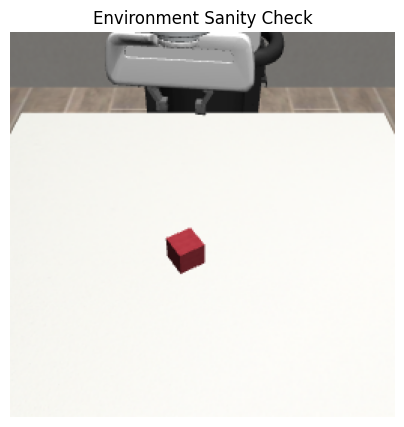

3. Render 成功 | 你应该能看到一张包含机械臂和红方块的图片。


In [73]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 测试环境重置 (Reset)

obs = wrapper.reset()
print(f"1. Reset 成功 | 初始观测维度: {obs.shape}")

# 2. 测试环境交互 (Step) - 执行一个随机动作
# 我们用全 0 动作或者随机动作测试
action = np.zeros(wrapper.action_space.shape) 
next_obs, reward, done, info = wrapper.step(action)
print(f"2. Step 成功  | Step后观测维度: {next_obs.shape}, Reward: {reward}")

# 3. 测试图像渲染 (Render) - 这是最容易报错的一步 (例如缺少 OpenGL 库)
try:
    img = wrapper.render()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title("Environment Sanity Check")
    plt.axis('off')
    plt.show()
    
    print("3. Render 成功 | 你应该能看到一张包含机械臂和红方块的图片。")
    
except Exception as e:
    print("\n[错误] 渲染失败！")
    print(f"错误信息: {e}")
    print("提示: 如果是在无头服务器(Headless Server)上，可能需要配置 EGL 或使用 xvfb-run。")

In [26]:
if stats['action']['min'].shape[0] != 10:
    print("⚠️ 警告: 你的 dataset stats 维度不是 10！")
    print(f"当前维度是: {stats['action']['min'].shape[0]}")
    print("可能原因：你加载的还是旧的 low_dim.hdf5，而不是 low_dim_abs.hdf5")

NameError: name 'stats' is not defined

### Dataset


In [27]:
from Common.myrotation_transformer_final import RotationTransformer

rotation_transformer = RotationTransformer('rotation_6d', 'axis_angle')

action_dim = 10 

print(f"已初始化 RotationTransformer，Action Dim 设置为: {action_dim}")

已初始化 RotationTransformer，Action Dim 设置为: 10


In [28]:
class MinMaxNormalizer:
    def __init__(self, data=None, min_val=None, max_val=None):
        """
        可以传入 data 自动计算 min/max，也可以直接传入已知的 min/max
        """
        if data is not None:
            # 假设 data 是 (N, Dim)
            self.min_val = np.min(data, axis=0)
            self.max_val = np.max(data, axis=0)
        else:
            self.min_val = np.array(min_val)
            self.max_val = np.array(max_val)
            
        # 防止除以零（如果某维度没有变化）
        self.scale = self.max_val - self.min_val
        self.scale[self.scale == 0] = 1.0 

    def normalize(self, x):
        # 归一化到 [0, 1]
        norm = (x - self.min_val) / self.scale
        # 映射到 [-1, 1]
        return norm * 2 - 1

    def denormalize(self, x):
        # 从 [-1, 1] 映射回 [0, 1]
        denorm = (x + 1) / 2
        # 还原到原始范围
        return denorm * self.scale + self.min_val

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from tqdm import tqdm

# 假设 RotationTransformer 和 MinMaxNormalizer 已经在上面定义好了
# from your_utils import RotationTransformer, MinMaxNormalizer 

class RobomimicDataset(Dataset):
    def __init__(self, 
                 dataset_path, 
                 obs_keys, 
                 pred_horizon, 
                 obs_horizon, 
                 action_horizon):
        
        # 参数记录
        self.pred_horizon = pred_horizon
        self.obs_horizon = obs_horizon
        self.action_horizon = action_horizon
        self.obs_keys = obs_keys
        
        # --- 新增：初始化旋转变换器 ---
        # 用于将 Axis-Angle (3) 转为 Rotation 6D (6)
        self.rotation_transformer = RotationTransformer(
            from_rep='axis_angle', to_rep='rotation_6d')

        # 1. 读取数据到内存
        print(f"正在加载数据集: {dataset_path}")
        with h5py.File(dataset_path, 'r') as f:
            demos = f['data']
            self.all_obs = []
            self.all_actions = [] # 这里将存储转换后的 10维动作
            
            for key in tqdm(demos.keys(), desc="Loading"):
                demo = demos[key]
                
                # --- 处理 Observation (保持不变) ---
                obs_list = []
                for k in self.obs_keys:
                    obs_data = demo['obs'][k][:] 
                    obs_list.append(obs_data)
                obs_seq = np.concatenate(obs_list, axis=-1)
                self.all_obs.append(obs_seq)
                
                # --- 修改重点：处理 Action (7维 -> 10维) ---
                raw_actions = demo['actions'][:].astype(np.float32) # (T, 7)
                
                # 1. 拆分动作
                pos = raw_actions[:, :3]     # (T, 3)
                rot = raw_actions[:, 3:6]    # (T, 3) Axis-Angle
                gripper = raw_actions[:, 6:] # (T, 1)
                
                # 2. 旋转变换 (Axis-Angle -> Rotation 6D)
                # Transformer 接收 Tensor，返回 Tensor，需转回 Numpy
                rot_tensor = torch.from_numpy(rot)
                rot_6d_tensor = self.rotation_transformer.forward(rot_tensor)
                rot_6d = rot_6d_tensor.numpy() # (T, 6)
                
                # 3. 拼接成绝对位置控制所需的格式 (T, 10)
                # 3 pos + 6 rot + 1 gripper = 10 dim
                new_actions = np.concatenate([pos, rot_6d, gripper], axis=-1)
                
                self.all_actions.append(new_actions)

        # 2. 计算统计数据并初始化归一化器
        # 把所有数据拼在一起
        all_obs_concat = np.concatenate(self.all_obs, axis=0)
        all_action_concat = np.concatenate(self.all_actions, axis=0)
        
        # --- 修改重点：使用类 MinMaxNormalizer ---
        # 此时 all_action_concat 已经是 10维的数据了
        self.obs_normalizer = MinMaxNormalizer(data=all_obs_concat)
        self.action_normalizer = MinMaxNormalizer(data=all_action_concat)
        
        # 打印一下验证维度
        print(f"原始 Action 维度: 7, 转换后 Action 维度: {all_action_concat.shape[-1]}")
        
        # 3. 预处理：归一化所有数据并建立索引
        self.normalized_obs = []
        self.normalized_actions = []
        self.indices = []
        
        for i in range(len(self.all_obs)):
            # --- 修改重点：调用实例方法进行归一化 ---
            n_obs = self.obs_normalizer.normalize(self.all_obs[i])
            n_action = self.action_normalizer.normalize(self.all_actions[i])
            
            self.normalized_obs.append(n_obs)
            self.normalized_actions.append(n_action)
            
            # 建立索引 (逻辑不变)
            episode_len = n_obs.shape[0]
            # 为了保证剩下的长度够 pred_horizon，需要减去它
            for start_ts in range(episode_len - self.pred_horizon):
                self.indices.append((i, start_ts))
                
        print(f"加载完成! 样本数量: {len(self.indices)}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        episode_idx, start_ts = self.indices[idx]
        
        n_obs = self.normalized_obs[episode_idx]
        n_action = self.normalized_actions[episode_idx]
        
        # 1. 取 Observation
        # 注意：这里如果 obs_horizon > 1，需要处理边界情况(padding)，
        # 但为简化起见，假设 start_ts + obs_horizon 不会越界(因为上面 range 只减了 pred_horizon)
        # 实际严谨代码通常会在上面 range 减去 max(obs_horizon, pred_horizon)
        obs_seq = n_obs[start_ts : start_ts + self.obs_horizon, :]
        
        # 2. 取 Action
        action_seq = n_action[start_ts : start_ts + self.pred_horizon, :]
        
        data = {
            'obs': torch.from_numpy(obs_seq).float(),      # shape: (obs_horizon, obs_dim)
            'action': torch.from_numpy(action_seq).float() # shape: (pred_horizon, 10)
        }
        return data

    # --- 新增：提供一个反归一化+逆变换的辅助函数，供推理时使用 ---
    def get_unnormalized_action(self, n_action_pred):
        """
        推理时使用：
        输入: 模型预测的归一化动作 (B, 10) Tensor or Numpy
        输出: 环境可执行的动作 (B, 7) Numpy
        """
        is_tensor = isinstance(n_action_pred, torch.Tensor)
        if is_tensor:
            n_action_pred = n_action_pred.detach().cpu().numpy()
            
        # 1. 反归一化 (10D -> 10D)
        action_10d = self.action_normalizer.denormalize(n_action_pred)
        
        # 2. 拆解
        pos = action_10d[..., :3]
        rot_6d = action_10d[..., 3:9]
        gripper = action_10d[..., 9:]
        
        # 3. 逆旋转变换 (6D -> 3D Axis-Angle)
        rot_6d_tensor = torch.from_numpy(rot_6d)
        rot_axis = self.rotation_transformer.inverse(rot_6d_tensor).numpy()
        
        # 4. 拼接 (10D -> 7D)
        action_7d = np.concatenate([pos, rot_axis, gripper], axis=-1)
        return action_7d

In [30]:
# 配置参数 (这些是 Diffusion Policy 的标准参数)
pred_horizon = 16    # 预测未来 16 步
obs_horizon = 2      # 看过去 2 步
action_horizon = 8   # (这一步在 dataset 里用不到，但在推理时有用)

# 1. 实例化 Dataset
dataset = RobomimicDataset(
    dataset_path=dataset_path, # 确保这个变量是你之前定义的路径
    obs_keys=[
        'object', 
        'robot0_eef_pos', 
        'robot0_eef_quat', 
        'robot0_gripper_qpos'
    ],
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)

# 2. 实例化 DataLoader
dataloader = DataLoader(
    dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=0, # 本地调试设为 0 比较稳妥，避免多进程报错
    pin_memory=True
)

# 3. 验证一下输出形状
batch = next(iter(dataloader))
print("\n--- 数据形状检查 ---")
print(f"Obs Batch:    {batch['obs'].shape}")
print(f"Action Batch: {batch['action'].shape}")
print(f"Observation Space: {wrapper.observation_space}")

正在加载数据集: /home/users/oscar/streaming-flow-policy/data/lift/ph/low_dim_abs.hdf5


Loading: 100%|██████████| 200/200 [00:00<00:00, 952.96it/s]

原始 Action 维度: 7, 转换后 Action 维度: 10
加载完成! 样本数量: 6466

--- 数据形状检查 ---
Obs Batch:    torch.Size([64, 2, 19])
Action Batch: torch.Size([64, 16, 10])
Observation Space: Box(-1.0, 1.0, (19,), float64)


### Model

In [31]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, scale = 1):
        super().__init__()
        self.dim = dim
        self.scale = scale # added - SFP

    def forward(self, x):
        x = x * self.scale
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ConvDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class ConvUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class LinearDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class LinearUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8,
                 ):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # Ensure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out

class ConditionalUnet1D (nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        updownsample_type: Literal['Conv', 'Linear'],  # added for SFP
        sin_embedding_scale,  # added for SFP
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8,
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed, scale = sin_embedding_scale), # added - SFP
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                downsample_layer = LinearDownsample1d(dim_out) if not is_last else nn.Identity() #added
            elif updownsample_type == 'Conv':
                downsample_layer = ConvDownsample1d(dim_out) if not is_last else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                downsample_layer,
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                upsample_layer = LinearUpsample1d(dim_in) if not is_last  else nn.Identity()
            elif updownsample_type == 'Conv':
                upsample_layer = ConvUpsample1d(dim_in) if not is_last  else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                upsample_layer,
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("Number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: Tensor,
            timestep: Union[Tensor, float, int],
            global_cond=None,
        ) -> Tensor:
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x

### DP

In [16]:
# 基于之前的 Lift 任务设置
action_dim = 10      # 动作维度
obs_dim = 19         # 观测特征维度
obs_horizon = 2      # 观测历史长度

# 实例化模型
dp_noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim * obs_horizon,
    updownsample_type='Conv',
    sin_embedding_scale=1,
)

print("模型构建成功！")

num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
dp_noise_pred_net = dp_noise_pred_net.to(device)

Number of parameters: 6.576897e+07
模型构建成功！


In [15]:
num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema_dp = EMAModel(
    parameters=dp_noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=dp_noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataset) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # Note that the data is normalized in the dataset.
                # Device transfer
                nobs = nbatch['obs'].to(device)  # (B, To, O)
                naction = nbatch['action'].to(device)  # (B, Tp, A)
                B = nobs.shape[0]

                # Observation as FiLM conditioning
                obs_cond = nobs.flatten(start_dim=1)  # (B, To*O)

                # Sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)  # (B, Tp, A)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()  # (B,)

                # Forward diffusion process: Add noise to the clean images
                # according to the noise magnitude at each diffusion iteration.
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)  # (B, Tp, A)

                # Predict the noise residual.
                noise_pred = dp_noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema_dp.step(dp_noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_noise_pred_net_dp = dp_noise_pred_net
ema_dp.copy_to(ema_noise_pred_net_dp.parameters())

Epoch:   1%|          | 1/100 [00:07<12:32,  7.60s/it, loss=1.02]


KeyboardInterrupt: 

In [ ]:
import collections
import numpy as np
import torch
from tqdm.auto import tqdm
import imageio  # 用于保存 GIF

# 1. 准备参数
# 确保模型处于推理模式
dp_noise_pred_net.eval()
dp_noise_pred_net.to(device)

# 设置参数 (必须与训练时一致)
max_steps = 400  # 最大运行步数
obs_horizon = 2
pred_horizon = 16
action_horizon = 8
num_diffusion_iters = 100 

# 2. 重置环境
obs = wrapper.reset()

# 初始化观测队列
obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)

# 用于保存可视化图像和奖励
imgs = [wrapper.render()]
rewards = list()
done = False
step_idx = 0

print("开始推理 (Inference)...")

# 3. 推理循环
with tqdm(total=max_steps, desc="Eval Robomimic") as pbar:
    while not done:
        # --- A. 数据准备 ---
        # 拼接最近 obs_horizon 步的观测数据
        obs_seq = np.stack(obs_deque) # (2, 19)
        
        # [修改点 1]: 使用 dataset 里的实例归一化器
        nobs = dataset.obs_normalizer.normalize(obs_seq)
        
        # 转 Tensor 并增加 Batch 维度
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
        
        # 构造 Global Conditioning: (1, obs_horizon * 19)
        obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

        # --- B. 生成动作 (反向扩散) ---
        with torch.no_grad():
            # [修改点 2]: 初始化纯高斯噪音，维度改为 10 (3pos + 6rot + 1gripper)
            # 原始代码是 7，现在必须是 10
            na_traj = torch.randn(
                (1, pred_horizon, 10), 
                device=device
            )

            # 设置调度器时间步
            noise_scheduler.set_timesteps(num_diffusion_iters)

            # 逐步去噪
            for k in noise_scheduler.timesteps:
                # 预测噪音
                noise_pred = dp_noise_pred_net(
                    sample=na_traj,
                    timestep=k,
                    global_cond=obs_cond
                )

                # 移除噪音
                na_traj = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=na_traj,
                ).prev_sample

        # --- C. 后处理 ---
        # 转回 CPU numpy: (1, 16, 10) -> (16, 10)
        na_traj = na_traj.detach().to('cpu').numpy()[0]
        
        # [修改点 3]: 调用 dataset 的辅助函数进行 反归一化 + 逆旋转变换
        # 输入 (16, 10) -> 输出 (16, 7)
        # 这个函数内部会自动处理: 10D反归一化 -> 6D旋转转AxisAngle -> 拼接回7D
        action_pred = dataset.get_unnormalized_action(na_traj)

        # --- D. 动作切片与执行 (逻辑不变) ---
        start = obs_horizon - 1
        end = start + action_horizon
        
        # 取出未来 action_horizon 步的动作
        action_chunk = action_pred[start:end, :] 
        
        # --- E. 执行动作序列 ---
        for action in action_chunk:
            # 环境交互 (此时 action 已经是环境能懂的 7维 格式了)
            obs, reward, done, info = wrapper.step(action)
            
            # 更新历史观测
            obs_deque.append(obs)
            
            # 记录数据
            rewards.append(reward)
            imgs.append(wrapper.render())
            
            # 进度更新
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            
            if step_idx >= max_steps:
                done = True
            if done:
                break

print(f"推理结束! 总得分: {max(rewards)}")

# 4. 保存结果为 GIF
save_path = "eval_robomimic_abs.gif"
print(f"正在保存视频到: {save_path} ...")
imageio.mimsave(save_path, imgs, fps=10)
print("保存完成！")

开始推理 (Inference)...


Eval Robomimic:   0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 总得分: 1.0
正在保存视频到: eval_robomimic_abs.gif ...
保存完成！


### SSIP

In [32]:
# =========================================================
# 1. 辅助函数: Gamma 调度器 (参考 model.py)
# =========================================================
EPS = 1e-6

def gamma_t_si(t):
    # 使用简单的抛物线/气泡形状，在 t=0 和 t=1 时为 0，中间膨胀
    # 这里的系数 0.1 控制 "SI 气泡" 的大小，相对于 SFP 的管状噪声
    return 0.1 * torch.sqrt(t * (1.0 - t) + EPS)

def d_gamma_dt_si(t):
    # gamma(t) 对 t 的导数
    return 0.1 * (1.0 - 2.0 * t) / (2.0 * torch.sqrt(t * (1.0 - t) + EPS))

# =========================================================
# 2. 初始化模型 (VelocityNet 和 DenoiserNet)
# =========================================================
# SFP 参数


pred_horizon = 16
action_dim = 10       # 动作维度
obs_dim = 19         # 观测特征维度
obs_horizon = 2      # 观测历史长度


# 我们需要两个网络：
# 1. si_velocity_net: 预测确定性速度场 (v)
# 2. si_denoiser_net: 预测噪声场 (eta/score)

si_velocity_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    updownsample_type='Linear',
    sin_embedding_scale=100,
).to(device)

si_denoiser_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    updownsample_type='Linear',
    sin_embedding_scale=100,
).to(device)

print("Models initialized for Streaming SI Policy.")

# =========================================================
# 3. 优化器设置
# =========================================================
optimizer_si = torch.optim.AdamW([
    {'params': si_velocity_net.parameters()},
    {'params': si_denoiser_net.parameters()}
], lr=1e-4, weight_decay=1e-6)

# EMA (Exponential Moving Average) for better inference stability
ema_si_v = EMAModel(parameters=si_velocity_net.parameters(), power=0.75)
ema_si_eta = EMAModel(parameters=si_denoiser_net.parameters(), power=0.75)

num_epochs_si = 800
lr_scheduler_si = get_scheduler(
    name='cosine',
    optimizer=optimizer_si,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs_si
)

Number of parameters: 6.413057e+07
Number of parameters: 6.413057e+07
Models initialized for Streaming SI Policy.


In [33]:
def LinearlyInterpolateTrajectory(ξ, t):
    """
    Vectorized computation of positions and velocities if each trajectory
    (from a batch of trajectories) at given times for each trajectory, using
    linear interpolation.

    ξ (Tensor, dtype=float, shape=(B, T, A)): batch of action trajectories.
    t (Tensor, dtype=float, shape=(B,)): batch of times in [0, 1].

    Returns:
        ξt   (Tensor, shape=(B, A)): positions at time t
        dξdt (Tensor, shape=(B, A)): velocities at time t
    """
    B, T, A = ξ.shape

    # Compute the lower and upper limits of the bins that the time-points lie in.
    scaled_t = t * (T - 1)  # (B,) lies in [0, T-1]
    l = scaled_t.floor().long().clamp(0, T - 2)  # (B,) lower bin limits
    u = (l + 1).clamp(0, T - 1)  # (B,) upper bin limits
    λ = scaled_t - l.float()  # fractional part, lies in [0, 1]

    # Query the values of the upper and lower bin limits.
    batch_idx = torch.arange(B, device=ξ.device)  # (B,)
    ξl = ξ[batch_idx, l, :]  # (B, A)
    ξu = ξ[batch_idx, u, :]  # (B, A)

    # Linearly interpolate between bin limits to get position.
    λ = λ.unsqueeze(-1)  # (B, 1)
    ξt = ξl + λ * (ξu - ξl)  # (B, A)

    # Compute velocity as first-order hold.
    # Note that the time interval between two bins is Δt = 1 / (T-1).
    dξdt = (ξu - ξl) * (T - 1)  # (B, A)

    return ξt, dξdt  # (B, A) and (B, A)

def SampleCFMInputsAndTargets(ξt, dξdt, t, k, σ0):
    """
    Sample inputs and targets for the conditional flow matching loss (CFM)
    given positions and velocities at time t.

    This functions performs the following sampling (Eq. 2 and 3 of the paper):
        a ~ N(ξ(t), σ₀² exp(-2kt))  # (Eq. 3 in the paper)
        v = -k (a - ξ(t)) + dξdt(t)  # (Eq. 2 in the paper)

    Args:
        ξt (Tensor, shape=(B, A)): positions at time t.
        dξdt (Tensor, shape=(B, A)): velocities at time t.
        t (Tensor, shape=(B,)): times in [0, 1].
        k (float): Stabilizing gains of the conditional flow.
        σ0 (float): initial standard deviation of the noise added to the action.

    Returns:
        a (Tensor, shape=(B, A)): noised actions at time t
        v (Tensor, shape=(B, A)): noised action velocity targets at time t
    """
    # error = σ0 * torch.exp(-k*t).unsqueeze(1) * torch.randn_like(xt)
    t = t.unsqueeze(-1)  # (B, 1)
    sampled_error = σ0 * torch.exp(-k * t) * torch.randn_like(ξt)  # (B, A)
    a = ξt + sampled_error  # (B, A) ⟸ Eq. 3 in the paper
    v = -k * sampled_error + dξdt  # (B, A) ⟸ Eq. 2 in the paper

    return a, v  # (B, A) and (B, A)

In [16]:
# =========================================================
# 训练循环: Conditional Streaming SI Policy
# =========================================================
sigma0 = 0.4  # SFP 初始管状半径
k = 10.0      # SFP 稳定系数


print("Starting training for Streaming SI Policy...")

with tqdm(range(num_epochs_si), desc='Epoch') as tglobal:
    for epoch_idx in tglobal:
        epoch_loss = []
        # 用于记录每个 epoch 的平均分项 loss
        epoch_v_loss = []
        epoch_eta_loss = []
        
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # 1. 数据准备
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                
                # 提取当前及未来的动作片段
                ξ = naction[:, obs_horizon-1:, :] 
                B = ξ.shape[0]
                
                # 随机采样时间 t ~ U[0, 1]
                t = torch.rand(B, device=device)
                
                # 2. 计算 Ground Truth 位置和速度 (Linearly Interpolate)
                ξt, dξdt = LinearlyInterpolateTrajectory(ξ, t)
                
                # 3. 构建 Flow Matching (FP) 基础目标 (管状分布)
                # a_t_fp = ξ(t) + σ(t) * ε1
                # 这里的 σ(t) = σ0 * exp(-kt)
                t_expanded = t.view(B, 1)
                sigma_t_fp = sigma0 * torch.exp(-k * t_expanded)
                noise_fp = torch.randn_like(ξt)
                a_t_fp = ξt + sigma_t_fp * noise_fp
                
                # 计算 Velocity Target (指向轨迹的向量场)
                # v_target = dξ/dt - k * (a_t_fp - ξ(t))
                # 注意：这个速度是定义在 a_t_fp 上的
                v_target = dξdt - k * (a_t_fp - ξt)
                
                # 4. 构建 Stochastic Interpolant (SI) 扰动
                # x_t = a_t_fp + γ(t) * z
                # 我们在 SFP 的管子外面再套一层 SI 的气泡
                gamma = gamma_t_si(t_expanded)
                z_noise_si = torch.randn_like(ξt)
                x_t_in_s = a_t_fp + gamma * z_noise_si
                
                # 5. 网络前向传播
                # 输入需要 reshape 成 (B, 1, A) 以适应 UNet 接口
                net_input = x_t_in_s.unsqueeze(1)
                global_cond = nobs.flatten(start_dim=1)
                
                # 预测速度
                v_pred = si_velocity_net(sample=net_input, timestep=t, global_cond=global_cond)
                v_pred = v_pred.squeeze(1)
                
                # 预测噪声 (Score 相关的量)
                eta_pred = si_denoiser_net(sample=net_input, timestep=t, global_cond=global_cond)
                eta_pred = eta_pred.squeeze(1)
                
                # 6. 计算 Loss
                loss_v = nn.functional.mse_loss(v_pred, v_target)
                loss_eta = nn.functional.mse_loss(eta_pred, z_noise_si)
                
                loss = loss_v + loss_eta
                
                # 7. 反向传播
                loss.backward()
                optimizer_si.step()
                optimizer_si.zero_grad()
                lr_scheduler_si.step()
                
                # 更新 EMA
                ema_si_v.step(si_velocity_net.parameters())
                ema_si_eta.step(si_denoiser_net.parameters())
                
                # 记录数据
                loss_val = loss.item()
                v_loss_val = loss_v.item()
                eta_loss_val = loss_eta.item()
                
                epoch_loss.append(loss_val)
                epoch_v_loss.append(v_loss_val)
                epoch_eta_loss.append(eta_loss_val)
                
                # [修改点] 这里增加了 s_loss (score loss) 的显示
                tepoch.set_postfix(loss=loss_val, v_loss=v_loss_val, s_loss=eta_loss_val)
                
        # [修改点] Epoch 结束时也可以看平均的分项 Loss
        tglobal.set_postfix(
            loss=np.mean(epoch_loss), 
            v_loss=np.mean(epoch_v_loss), 
            s_loss=np.mean(epoch_eta_loss)
        )

        if (epoch_idx + 1) % 200 == 0:
            ckpt_path_epoch = f"models/lift_state_{epoch_idx+1}_ep_si_abs.ckpt"
            torch.save({
                'velocity_net': si_velocity_net.state_dict(),
                'denoiser_net': si_denoiser_net.state_dict()
            }, ckpt_path_epoch)
            print(f" Saved checkpoint to {ckpt_path_epoch}")

# 保存模型
ckpt_path_si = "models/lift_state_500_ep_si_abs.ckpt"
torch.save({
    'velocity_net': si_velocity_net.state_dict(),
    'denoiser_net': si_denoiser_net.state_dict()
}, ckpt_path_si)
print(f"Saved Streaming SI model to {ckpt_path_si}")

# 准备推理用的 EMA 模型
ema_si_velocity_net = si_velocity_net
ema_si_denoiser_net = si_denoiser_net
ema_si_v.copy_to(ema_si_velocity_net.parameters())
ema_si_eta.copy_to(ema_si_denoiser_net.parameters())

Starting training for Streaming SI Policy...


Epoch:   0%|          | 0/800 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [34]:
# =========================================================
# 加载预训练的 Streaming SI Policy 模型 (跳过训练)
# =========================================================

load_pretrained = True
ckpt_path_si = "models/lift_state_800_ep_si_abs.ckpt"

# 检查文件是否存在
if load_pretrained and os.path.isfile(ckpt_path_si):
    print(f"Found pretrained checkpoint: {ckpt_path_si}")
    checkpoint = torch.load(ckpt_path_si, map_location=device)

    # 1. 加载权重到基础网络
    si_velocity_net.load_state_dict(checkpoint['velocity_net'])
    si_denoiser_net.load_state_dict(checkpoint['denoiser_net'])

    # 2. 设置推理用的模型
    # 在跳过训练的情况下，我们将直接使用加载的权重作为推理模型
    # (模拟 EMA 模型及其接口)
    ema_si_velocity_net = si_velocity_net
    ema_si_denoiser_net = si_denoiser_net

    print('Pretrained weights loaded for Streaming SI Policy. Ready for inference!')

else:
    print(f"Checkpoint {ckpt_path_si} not found. Please run the training cell below.")
    # 如果需要，这里可以初始化 EMA 模型容器，以便后续训练使用
    # ema_si_velocity_net = ... (通常在训练循环中通过 EMAModel 初始化)

Found pretrained checkpoint: models/lift_state_800_ep_si_abs.ckpt
Pretrained weights loaded for Streaming SI Policy. Ready for inference!


In [35]:
import collections
import numpy as np
import torch
import math
import imageio
from tqdm.auto import tqdm
from scipy.spatial.transform import Rotation as R

# =========================================================
# 辅助函数: 计算 Drift (适配 10维 Action)
# =========================================================
def get_drift(x, t, global_cond, sigma_infer, eps=1e-6):
    """
    计算修正后的漂移项 b(x, t)
    x: (B, 1, 10)
    """
    if t.ndim == 0: t = t.unsqueeze(0)
    
    # 预测 v 和 eta
    v_pred = ema_si_velocity_net(sample=x, timestep=t, global_cond=global_cond)
    eta_pred = ema_si_denoiser_net(sample=x, timestep=t, global_cond=global_cond)
    
    # 获取 gamma 及其导数
    gamma = gamma_t_si(t).view(-1, 1, 1).to(device)
    gamma_dot = d_gamma_dt_si(t).view(-1, 1, 1).to(device)
    
    # 计算 score 和 漂移系数
    s_pred = -eta_pred / (gamma + eps)
    score_coeff = 0.5 * (sigma_infer ** 2) - (gamma * gamma_dot)
    
    b = v_pred + score_coeff * s_pred
    return b

# =========================================================
# 核心修复: SSIP 推理函数 (Absolute Control 适配版)
# =========================================================
def run_si_inference(sigma_infer, title):
    # 1. 重置环境
    obs = wrapper.reset() 
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [wrapper.render()]
    rewards = []
    
    # 2. Warm Start: 基于当前观测构建初始流状态 x_0
    # -----------------------------------------------------------
    # [关键]: 必须准确地将当前 obs 转换为 10维的 latent action 格式
    # -----------------------------------------------------------
    
    start_dim = 10 
    curr_pos = obs[start_dim : start_dim+3] # 取出 (x, y, z)
    
    # 2. 归一化当前位置
    pos_min = dataset.action_normalizer.min_val[:3]
    pos_max = dataset.action_normalizer.max_val[:3]
    norm_pos = (curr_pos - pos_min) / (pos_max - pos_min)
    norm_pos = norm_pos * 2 - 1
    
    # 3. 初始化 na (Latent State)
    # 维度: (1, 1, 10)
    na = torch.zeros((1, 1, 10), device=device, dtype=torch.float32)
    
    # [Fix 1]: 覆盖位置 (保持不变)
    na[0, 0, :3] = torch.from_numpy(norm_pos).to(device)
    
    # [Fix 2 - 关键]: 强制初始化夹爪为 "张开" (-1.0)
    # 假设第 10 维 (索引 9) 是夹爪。
    # 在归一化空间中，-1 通常代表 raw action 的最小值 (Open)
    na[0, 0, 9] = -1 
    
    # [Fix 3 - 可选]: 旋转初始化为 0 (6D Rotation) 可能不是单位矩阵
    # 6D Rotation 的 [0,0,0,0,0,0] 是退化的。
    # 更严谨的做法是初始化为 正确的矩阵，但这里我没有整明白，然后这个一堆0又work了，我就不管了哈哈

    
    # 设置为流的起点
    na_from_prev_chunk = na
    
    # =========================================================
    
    done = False
    step_idx = 0
    max_steps = 400 
    dt_val = 1.0 / (pred_horizon - obs_horizon) # 流的时间步长
    
    print(f"Running Inference: {title} (sigma={sigma_infer})")
    
    with torch.no_grad():
        with tqdm(total=max_steps, desc=title) as pbar:
            while not done and step_idx < max_steps:
                # --- A. 准备 Observation ---
                obs_seq = np.stack(obs_deque)
                # [修复点]: 使用 dataset.obs_normalizer
                nobs = dataset.obs_normalizer.normalize(obs_seq)
                o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
                
                # --- B. Streaming Loop ---
                na = na_from_prev_chunk
                
                for i in range(action_horizon):
                    # 1. 解码当前动作并执行
                    # [修复点]: 使用 dataset.get_unnormalized_action 自动处理反归一化+6D转回
                    a_real_full = dataset.get_unnormalized_action(na) # 返回 (1, 1, 7) numpy
                    a_real = a_real_full.squeeze() # (7,)
                    
                    # 环境交互
                    obs, reward, done, info = wrapper.step(a_real)
                    
                    obs_deque.append(obs)
                    rewards.append(reward)
                    imgs.append(wrapper.render())
                    
                    step_idx += 1
                    pbar.update(1)
                    pbar.set_postfix(reward=reward)
                    
                    if done or step_idx >= max_steps: break
                    
                    # 2. 积分 (Euler Step) 计算下一个时间步的动作
                    t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)
                    t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                    
                    b_drift = get_drift(na, t, o_test, sigma_infer)
                    noise = torch.randn_like(na)
                    diffusion = sigma_infer * math.sqrt(dt_val) * noise
                    
                    na = na + b_drift * dt_val + diffusion
                
                # 更新流的起点 (Streaming)
                na_from_prev_chunk = na
                
                if done: break

    print(f"推理结束! 最高得分: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 执行推理
# =========================================================

# 1. ODE 模式 (平滑)
imgs_ode = run_si_inference(sigma_infer=0.0, title="Streaming SI (ODE Mode)")
imageio.mimsave("eval_ssip_ode_abs.gif", imgs_ode, fps=10)

# 2. SDE 模式 (探索)
imgs_sde = run_si_inference(sigma_infer=0.05, title="Streaming SI (SDE Mode)")
imageio.mimsave("eval_ssip_sde_abs.gif", imgs_sde, fps=10)

Running Inference: Streaming SI (ODE Mode) (sigma=0.0)


Streaming SI (ODE Mode):   0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 最高得分: 1.0
Running Inference: Streaming SI (SDE Mode) (sigma=0.05)


Streaming SI (SDE Mode):   0%|          | 0/400 [00:00<?, ?it/s]


推理结束! 最高得分: 1.0


### STEG Implementation Archived

In [26]:
import numpy as np
import torch
import cv2
import collections
import math
from tqdm.auto import tqdm
import imageio

# =========================================================
# 1. 辅助工具: 3D 到 2D 的简单投影 & 绘图
# =========================================================
def project_3d_to_2d_heuristic(pos_3d, img_size=(256, 256)):
    """
    一个简单的启发式投影，将 Robosuite 的 3D 坐标映射到 AgentView 的 2D 像素坐标。
    注意：这只是一个近似值，用于可视化箭头方向。准确投影需要 env.sim 的相机矩阵。
    """
    x, y, z = pos_3d
    h, w = img_size
    
    # 针对 Robosuite Lift 环境 AgentView 的经验参数
    # 如果箭头位置不对，可以微调这里
    scale_x = 180.0
    scale_y = 180.0
    offset_x = 128.0 
    offset_y = 128.0 
    
    # Robosuite坐标系: x向前, y向左, z向上
    # 图片坐标系: u向右, v向下
    # 简单的透视/正交模拟
    u = int(-y * scale_x + offset_x)
    v = int(h - (x * scale_y + offset_y + z * 50)) # z轴增加会让物体在图里看起来更高(v更小)
    
    return (u, v)

def draw_vector_arrow_3d(img, start_pos_3d, vector_3d, color, scale=1.0, thickness=2):
    """
    在图像上绘制 3D 向量的 2D 投影
    """
    if vector_3d is None or np.linalg.norm(vector_3d) < 1e-6:
        return

    # 计算 3D 空间中的终点
    end_pos_3d = start_pos_3d + vector_3d * scale
    
    # 投影到像素
    start_px = project_3d_to_2d_heuristic(start_pos_3d, img_size=img.shape[:2])
    end_px = project_3d_to_2d_heuristic(end_pos_3d, img_size=img.shape[:2])
    
    # 绘制箭头
    cv2.arrowedLine(img, start_px, end_px, color, thickness, tipLength=0.3)

# =========================================================
# 2. TEG Inference for Lift (SSIP + 3D Obstacle)
# =========================================================

def run_teg_inference_lift(obstacle_pos_3d, guidance_scale=20.0, N_ensemble=32):
    """
    obstacle_pos_3d: [x, y, z] list or np.array, 障碍物的绝对物理坐标
    """
    # 1. 环境初始化
    obs = wrapper.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [wrapper.render()]
    rewards = []
    
    # 2. 准备障碍物 Tensor (用于计算 Cost)
    # 我们将其归一化到 Latent Space，因为梯度是在 Latent Space 计算的更稳定
    # 注意：只取前3维 (Position)
    obs_pos_phys = np.array(obstacle_pos_3d)
    
    # 归一化障碍物位置
    pos_min = dataset.action_normalizer.min_val[:3]
    pos_max = dataset.action_normalizer.max_val[:3]
    obs_pos_norm = (obs_pos_phys - pos_min) / (pos_max - pos_min) * 2 - 1
    
    # 转为 Tensor (N, 3)
    target_obs_tensor = torch.tensor(obs_pos_norm, device=device, dtype=torch.float32).repeat(N_ensemble, 1)

    # 3. Warm Start (同 SSIP Inference)
    start_dim = 10 
    curr_pos = obs[start_dim : start_dim+3]
    norm_pos = (curr_pos - pos_min) / (pos_max - pos_min) * 2 - 1
    
    na = torch.zeros((1, 1, 10), device=device, dtype=torch.float32)
    na[0, 0, :3] = torch.from_numpy(norm_pos).to(device)
    na[0, 0, 9] = -1 # Gripper Open
    na_from_prev_chunk = na
    
    # 参数设置
    done = False
    step_idx = 0
    max_steps = 200
    dt_real = 1.0 / (pred_horizon - obs_horizon)
    
    # TEG 参数
    K_horizon = 5         # 向前模拟步数
    dt_est = 0.1          # 模拟步长
    activation_distance = 10  # 归一化空间下的激活距离 (需要根据 Latent Space 的尺度调整)
    sigma_est = 0.1       # 模拟时的噪声强度
    
    # 可视化参数
    vis_arrow_scale = 0.5 # 物理空间下箭头的长度缩放
    
    print(f"Running TEG on Lift: Obstacle at {obstacle_pos_3d}")
    
    with tqdm(total=max_steps, desc="TEG Lift") as pbar:
        while not done and step_idx < max_steps:
            # --- A. Observation ---
            obs_seq = np.stack(obs_deque)
            nobs = dataset.obs_normalizer.normalize(obs_seq)
            o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
            
            na = na_from_prev_chunk
            
            for i in range(action_horizon):
                # -------------------------------------------------
                # 1. 计算 Base Drift (原始策略场)
                # -------------------------------------------------
                t_scalar = np.clip(i * dt_real, 1e-3, 1.0 - 1e-3)
                t_tensor = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                
                with torch.no_grad():
                    base_drift = get_drift(na, t_tensor, o_test, sigma_infer=0.0) # 基础漂移不加噪
                
                # -------------------------------------------------
                # 2. TEG: 计算避障梯度 (Repulsive Force)
                # -------------------------------------------------
                # 计算当前 Latent Position 与障碍物的距离
                curr_na_pos = na[0, 0, :3]
                dist_to_obs = torch.norm(curr_na_pos - target_obs_tensor[0]).item()
                
                grad_teg = torch.zeros_like(base_drift)
                dynamic_scale = 0.0
                
                # 只有当距离小于阈值时才启动昂贵的梯度计算
                if dist_to_obs < activation_distance:
                    with torch.enable_grad():
                        # 复制当前状态用于模拟
                        # na: (1, 1, 10)
                        a_curr = na.detach().requires_grad_(True)
                        
                        # Batch Expansion: (N, 1, 10)
                        a_ens = a_curr.repeat(N_ensemble, 1, 1)
                        t_ens = t_tensor.expand(N_ensemble)
                        cond_ens = o_test.expand(N_ensemble, -1)
                        
                        cum_cost = torch.zeros(N_ensemble, device=device)
                        curr_a_sim = a_ens
                        curr_t_sim = t_ens
                        
                        # --- K步 模拟循环 ---
                        for k_sim in range(K_horizon):
                            # 预测速度
                            t_input = torch.clamp(curr_t_sim, 0.0, 1.0)
                            v_p = ema_si_velocity_net(curr_a_sim, t_input, cond_ens) # (N, 1, 10)
                            
                            # 这里为了速度，模拟时只用 VelocityNet 的 Euler 积分，暂不计算 Score 修正
                            # (在 Push-T 经验中，仅用 v_p 足够估算未来轨迹)
                            b_drift_sim = v_p 
                            
                            # 计算 Cost: 只看前3维 (XYZ)
                            # 高斯势场: exp(-dist^2 / sigma^2)
                            # 距离越近，Cost 越高
                            sim_pos = curr_a_sim[:, 0, :3] # (N, 3)
                            dist_sq = ((sim_pos - target_obs_tensor)**2).sum(dim=-1) # (N,)
                            step_cost = torch.exp(-dist_sq / (2 * 0.15**2)) # 0.15 是势场宽度
                            
                            cum_cost += step_cost * dt_est
                            
                            # 更新状态
                            noise = torch.randn_like(curr_a_sim)
                            curr_a_sim = curr_a_sim + b_drift_sim * dt_est + sigma_est * math.sqrt(dt_est) * noise
                            curr_t_sim = curr_t_sim + dt_est
                        
                        # --- 计算梯度 ---
                        # 我们希望最小化 Cost，即最大化 -Cost
                        # TEG Paper: grad log( sum exp(-Cost) )
                        neg_cost = -cum_cost # We want to minimize cost -> maximize utility
                        log_utility = torch.logsumexp(neg_cost, dim=0)
                        
                        # 对当前动作求导
                        (g,) = torch.autograd.grad(log_utility, a_curr)
                        grad_teg = g # (1, 1, 10)
                        
                        # 确保梯度只作用于位置 (XYZ)，清零旋转和夹爪的梯度
                        # 这是一个非常重要的步骤，防止避障破坏抓取姿态
                        grad_mask = torch.zeros_like(grad_teg)
                        grad_mask[:, :, :3] = 1.0
                        grad_teg = grad_teg * grad_mask
                    
                    # 动态权重：距离越近，权重越大
                    # Linear ramp: (1 - dist/threshold)
                    dynamic_scale = guidance_scale * max(0, (1.0 - dist_to_obs / activation_distance))

                # -------------------------------------------------
                # 3. 可视化绘制 (Render Vectors)
                # -------------------------------------------------
                img_rgb = wrapper.render().copy()
                
                # 获取当前的物理位置 (用于画起点)
                curr_phys_10d = dataset.action_normalizer.denormalize(na.detach().cpu().numpy().squeeze())
                curr_phys_pos = curr_phys_10d[:3]
                
                # 1. 绘制障碍物 (黄色球)
                # 投影并画圆圈模拟球体
                obs_px = project_3d_to_2d_heuristic(obs_pos_phys)
                cv2.circle(img_rgb, obs_px, 10, (0, 255, 255), -1)
                cv2.putText(img_rgb, "OBSTACLE", (obs_px[0]-30, obs_px[1]-15), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)

                # 2. 准备向量 (转换回物理空间尺度以便可视化)
                # 注意：Latent空间的向量数值在 [-1, 1] 之间，直接画可能很小
                # 我们这里直接画 Latent 向量的方向，乘以前面定义的 vis_arrow_scale
                
                vec_base_np = base_drift[0,0,:3].detach().cpu().numpy()
                vec_teg_np = (grad_teg[0,0,:3] * dynamic_scale).detach().cpu().numpy()
                
                # 绘制 Base Drift (蓝色: 原始意图)
                draw_vector_arrow_3d(img_rgb, curr_phys_pos, vec_base_np, (255, 0, 0), scale=vis_arrow_scale)
                
                # 绘制 TEG Repulsion (红色: 避障力)
                if dynamic_scale > 1e-4:
                    draw_vector_arrow_3d(img_rgb, curr_phys_pos, vec_teg_np, (0, 0, 255), scale=vis_arrow_scale)
                    cv2.putText(img_rgb, f"TEG: {dynamic_scale:.2f}", (10, 30), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

                imgs.append(img_rgb)

                # -------------------------------------------------
                # 4. 执行动作更新 & 环境交互
                # -------------------------------------------------
                
                # 组合漂移: Base + Guidance
                total_drift = base_drift + dynamic_scale * grad_teg
                
                # SDE 更新 (加一点点噪声增加鲁棒性)
                noise = torch.randn_like(na)
                # 这里 sigma 取小一点，比如 0.01，避免震荡
                diffusion = 0.01 * math.sqrt(dt_real) * noise
                
                na = na + total_drift * dt_real + diffusion
                na = na.detach() # 截断梯度
                
                # 解码动作并执行
                action_7d = dataset.get_unnormalized_action(na.cpu().numpy()).squeeze()
                
                obs, reward, done, info = wrapper.step(action_7d)
                obs_deque.append(obs)
                rewards.append(reward)
                
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(rew=reward, teg=dynamic_scale)
                
                if done or step_idx >= max_steps: break
            
            na_from_prev_chunk = na
            if done: break
            
    print(f"Final Score: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 3. 运行测试
# =========================================================

# 设置障碍物位置 [x, y, z]
# 根据 Lift 任务，方块大约在 [0.1, 0, 0.85] 左右
# 我们在路径中间放一个障碍物，迫使它绕路
# 比如放在 [0.05, 0.0, 0.9] (稍微高一点，挡在去方块的路上)
obstacle_pos = [0.0, -0.1, 0.95] 

# 运行推理
# guidance_scale 越大，斥力越强
imgs_teg = run_teg_inference_lift(obstacle_pos, guidance_scale=10.0, N_ensemble=32)

# 保存 GIF
save_path = "eval_teg_lift.gif"
print(f"Saving GIF to {save_path}...")
imageio.mimsave(save_path, imgs_teg, fps=15)
print("Done!")

Running TEG on Lift: Obstacle at [0.0, -0.1, 0.95]


TEG Lift:   0%|          | 0/200 [00:00<?, ?it/s]

Final Score: 0.0
Saving GIF to eval_teg_lift.gif...
Done!


In [36]:
import numpy as np
import torch
import cv2
import collections
import math
import imageio
from tqdm.auto import tqdm

# =========================================================
# 1. 可视化辅助工具
# =========================================================
def draw_vector_arrow_2d(img, start_px, vector_2d, color, scale=100, thickness=2):
    """
    在图像上绘制 2D 向量箭头 (仅可视化 X, Y 分量)
    """
    if vector_2d is None or np.linalg.norm(vector_2d) < 1e-6:
        return
    
    # 计算终点 (注意 opencv 坐标系: x水平向右, y垂直向下)
    # Lift 环境的坐标系通常与图像坐标系有旋转关系，这里做简单的直接映射用于示意
    # 如果箭头方向反了，可以调整符号
    end_px = (int(start_px[0] + vector_2d[1] * scale),  # 简单的映射尝试，根据实际画面调整
              int(start_px[1] - vector_2d[0] * scale))
    
    try:
        cv2.arrowedLine(img, start_px, end_px, color, thickness, tipLength=0.3)
    except:
        pass

def world_to_pixel_heuristic(pos_3d):
    """
    将 3D 物理坐标 (x,y,z) 映射到 2D 像素坐标的启发式函数。
    注意：在没有真实相机矩阵的情况下，这是一个近似映射，仅用于可视化。
    Lift 环境通常 AgentView 是斜视。
    """
    # 这里的参数是根据典型的 Robosuite Lift AgentView 手调的近似值
    # 实际应用中最好使用 muojco 的 camera matrix
    x, y, z = pos_3d
    img_size = 256 # 假设渲染尺寸
    
    # 简单的透视投影模拟
    u = 128 + int(y * 600)  
    v = 200 - int(z * 600) 
    return (u, v)

# =========================================================
# 2. TEG 推理核心函数 (带避障)
# =========================================================
def run_ssip_teg_inference(
    obstacle_pos_phys, 
    guidance_scale=10.0, 
    activation_dist=0.3, 
    N_ensemble=32,       
    K_horizon=5          
):
    # --- 准备工作 ---
    obs = wrapper.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [wrapper.render()]
    rewards = []
    
    # [修复]: 确保 obstacle_pos_phys 也是 float32
    obs_phys_tensor = torch.tensor(obstacle_pos_phys, device=device, dtype=torch.float32)
    
    start_dim = 10 
    curr_pos = obs[start_dim : start_dim+3] 
    
    pos_min = dataset.action_normalizer.min_val[:3]
    pos_max = dataset.action_normalizer.max_val[:3]
    norm_pos = (curr_pos - pos_min) / (pos_max - pos_min)
    norm_pos = norm_pos * 2 - 1
    
    na = torch.zeros((1, 1, 10), device=device, dtype=torch.float32)
    na[0, 0, :3] = torch.from_numpy(norm_pos).to(device, dtype=torch.float32) # 确保 float32
    na[0, 0, 9] = -1 
    
    na_from_prev_chunk = na
    
    done = False
    step_idx = 0
    max_steps = 400
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    dt_est = 0.1 
    sigma_infer = 0.05 
    
    print(f"Running SSIP with TEG Obstacle Avoidance...")
    print(f"Target Obstacle: {obstacle_pos_phys}")

    with torch.no_grad():
        with tqdm(total=max_steps, desc="SSIP+TEG") as pbar:
            while not done and step_idx < max_steps:
                obs_seq = np.stack(obs_deque)
                nobs = dataset.obs_normalizer.normalize(obs_seq)
                o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
                
                na = na_from_prev_chunk
                
                for i in range(action_horizon):
                    t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)

                    # ---------------------------------------------------------
                    # 1. 计算 TEG 梯度
                    # ---------------------------------------------------------
                    grad_teg = torch.zeros_like(na)
                    dynamic_scale = 0.0
                    
                    curr_action_phys = dataset.get_unnormalized_action(na) 
                    curr_xyz = torch.tensor(curr_action_phys[0,0,:3], device=device, dtype=torch.float32)
                    dist_to_obs = torch.norm(curr_xyz - obs_phys_tensor).item()
                    
                    if dist_to_obs < activation_dist:
                        with torch.enable_grad():
                            na_in = na.squeeze(1).detach().requires_grad_(True)
                            
                            na_ens = na_in.repeat(N_ensemble, 1) 
                            
                            # [关键修复 1]: 显式指定 dtype=torch.float32，否则 np.clip 返回的 float64 会导致 tensor 变成 double
                            t_ens = torch.tensor([t_scalar], device=device, dtype=torch.float32).repeat(N_ensemble)
                            cond_ens = o_test.repeat(N_ensemble, 1)
                            
                            curr_na_sim = na_ens
                            curr_t_sim = t_ens
                            cum_cost = torch.zeros(N_ensemble, device=device, dtype=torch.float32)
                            
                            for k_step in range(K_horizon):
                                t_input = torch.clamp(curr_t_sim, 0.05, 0.95)
                                
                                # 网络输入必须全是 float32
                                v_p = ema_si_velocity_net(curr_na_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                                eta_p = ema_si_denoiser_net(curr_na_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                                
                                gamma = gamma_t_si(t_input).view(-1, 1)
                                g_dot = d_gamma_dt_si(t_input).view(-1, 1)
                                s_p = -eta_p / (gamma + 1e-6)
                                sigma_est = 0.05 
                                score_coeff = 0.5 * (sigma_est**2) - (gamma * g_dot)
                                b_drift = v_p + score_coeff * s_p
                                
                                # [关键修复 2]: min_val/max_val 是 numpy float64，必须转为 float32
                                min_v = torch.from_numpy(dataset.action_normalizer.min_val).to(device, dtype=torch.float32)
                                max_v = torch.from_numpy(dataset.action_normalizer.max_val).to(device, dtype=torch.float32)
                                scale_v = max_v - min_v
                                scale_v[scale_v==0] = 1.0
                                
                                denorm_sim = ((curr_na_sim + 1) / 2) * scale_v + min_v
                                sim_xyz = denorm_sim[:, :3]
                                
                                dist_sq = ((sim_xyz - obs_phys_tensor)**2).sum(dim=-1)
                                cost_step = torch.exp(-dist_sq / (2 * 0.05**2)) 
                                cum_cost = cum_cost + cost_step * dt_est
                                
                                curr_na_sim = curr_na_sim + b_drift * dt_est
                                curr_t_sim = curr_t_sim + dt_est
                                
                            neg_cost = -cum_cost
                            log_utility = torch.logsumexp(neg_cost, dim=0)
                            
                            (g,) = torch.autograd.grad(log_utility, na_in)
                            grad_teg = g.unsqueeze(1)
                            
                        dynamic_scale = guidance_scale * max(0, (1.0 - dist_to_obs / activation_dist))
                    
                    # ---------------------------------------------------------
                    # 2. Base Policy
                    # ---------------------------------------------------------
                    t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                    b_drift_base = get_drift(na, t, o_test, sigma_infer)
                    
                    # ---------------------------------------------------------
                    # 3. Update
                    # ---------------------------------------------------------
                    total_drift = b_drift_base + dynamic_scale * grad_teg
                    
                    noise = torch.randn_like(na)
                    diffusion = sigma_infer * math.sqrt(dt_val) * noise
                    
                    na = na + total_drift * dt_val + diffusion
                    
                    # ---------------------------------------------------------
                    # 4. Step & Vis
                    # ---------------------------------------------------------
                    a_real_full = dataset.get_unnormalized_action(na)
                    a_real = a_real_full.squeeze()
                    obs, reward, done, info = wrapper.step(a_real)
                    
                    obs_deque.append(obs)
                    rewards.append(reward)
                    
                    img_rgb = wrapper.render().copy()
                    
                    if img_rgb.shape[0] > 64:
                        obs_px = world_to_pixel_heuristic(obstacle_pos_phys)
                        curr_px = world_to_pixel_heuristic(curr_xyz.detach().cpu().numpy())
                        
                        cv2.circle(img_rgb, obs_px, 5, (255, 255, 0), -1)
                        cv2.circle(img_rgb, curr_px, 5, (0, 0, 255), -1)
                        
                        if dynamic_scale > 1e-4:
                            vec_teg = (grad_teg * dynamic_scale).detach().cpu().numpy().squeeze()[:2]
                            draw_vector_arrow_2d(img_rgb, curr_px, vec_teg, (0, 255, 0), scale=200, thickness=2)
                    
                    imgs.append(img_rgb)
                    
                    step_idx += 1
                    pbar.update(1)
                    pbar.set_postfix(reward=reward)
                    
                    if done or step_idx >= max_steps: break
                
                na_from_prev_chunk = na
                if done: break

    print(f"推理结束! 最高得分: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 3. 运行示例
# =========================================================

# 定义一个虚拟障碍物位置 (x, y, z)
# Lift 环境中，方块通常在 [0, 0, 0] 附近，机械臂在上方
# 我们在方块上方或侧面放一个障碍物，强迫机械臂绕行
obstacle_pos = np.array([-0.02, 0.08, 0.8]) 

# 运行推理
imgs_teg = run_ssip_teg_inference(
    obstacle_pos_phys=obstacle_pos,
    guidance_scale=8.0,   # 这里的 scale 可以根据效果调整，越大斥力越强
    activation_dist=0.25, # 当距离小于 25cm 时触发避障
    N_ensemble=16         # 并行采样数，显存够可以开大
)

# 保存 GIF
save_path = "eval_ssip_teg_avoidance.gif"
print(f"正在保存视频到: {save_path} ...")
imageio.mimsave(save_path, imgs_teg, fps=15)
print("保存完成！")

Running SSIP with TEG Obstacle Avoidance...
Target Obstacle: [-0.02  0.08  0.8 ]


SSIP+TEG:   0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 最高得分: 1.0
正在保存视频到: eval_ssip_teg_avoidance.gif ...
保存完成！


In [ ]:
import numpy as np
import torch
import cv2
import collections
import math
import imageio
from tqdm.auto import tqdm

# =========================================================
# 工具函数: MuJoCo 真实坐标投影
# =========================================================
def world_to_pixel_mujoco(sim, pos_3d, camera_name, img_h, img_w):
    """ 利用 MuJoCo 内参矩阵进行精确投影 """
    try:
        cam_id = sim.model.camera_name2id(camera_name)
        cam_pos = sim.data.cam_xpos[cam_id]
        cam_mat = sim.data.cam_xmat[cam_id].reshape(3, 3)
        
        pos_rel = pos_3d - cam_pos
        pos_cam_opengl = cam_mat.T @ pos_rel
        
        x, y, z = pos_cam_opengl[0], -pos_cam_opengl[1], -pos_cam_opengl[2]
        
        if z < 0.01: return None
            
        fovy = sim.model.cam_fovy[cam_id]
        f = 0.5 * img_h / np.tan(fovy * np.pi / 360)
        cx, cy = img_w / 2, img_h / 2
        
        u = int(cx + f * x / z)
        v = int(cy + f * y / z)
        
        if 0 <= u < img_w and 0 <= v < img_h:
            return (u, v)
        return None
    except Exception as e:
        # print(f"Proj Error: {e}") 
        return None

# =========================================================
# 推理函数 (集成版)
# =========================================================
def run_ssip_teg_inference_accurate_vis(
    obstacle_pos_phys, 
    guidance_scale=15.0, 
    activation_dist=0.3, 
    N_ensemble=16,       
    update_interval=4    
):
    # 1. 重置环境
    obs = wrapper.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [wrapper.render()]
    rewards = []
    
    # 确保障碍物坐标是 float32 Tensor
    obs_phys_tensor = torch.tensor(obstacle_pos_phys, device=device, dtype=torch.float32)
    
    # 初始化 Latent Action (na)
    start_dim = 10 
    curr_pos = obs[start_dim : start_dim+3] 
    pos_min = dataset.action_normalizer.min_val[:3]
    pos_max = dataset.action_normalizer.max_val[:3]
    norm_pos = (curr_pos - pos_min) / (pos_max - pos_min) * 2 - 1
    
    na = torch.zeros((1, 1, 10), device=device, dtype=torch.float32)
    na[0, 0, :3] = torch.from_numpy(norm_pos).to(device, dtype=torch.float32)
    na[0, 0, 9] = -1 
    na_from_prev_chunk = na
    
    # 缓存变量
    cached_grad = torch.zeros_like(na)
    cached_scale = 0.0
    
    done = False
    step_idx = 0
    max_steps = 400
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    sigma_infer = 0.05 

    print(f"Running Inference with Accurate Projection...")

    with torch.no_grad():
        with tqdm(total=max_steps) as pbar:
            while not done and step_idx < max_steps:
                obs_seq = np.stack(obs_deque)
                nobs = dataset.obs_normalizer.normalize(obs_seq)
                o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
                
                na = na_from_prev_chunk
                
                for i in range(action_horizon):
                    t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)

                    # --- 1. TEG 计算 (省略具体逻辑，与之前相同，重点在下面的可视化) ---
                    curr_action_phys = dataset.get_unnormalized_action(na) 
                    curr_xyz = torch.tensor(curr_action_phys[0,0,:3], device=device, dtype=torch.float32)
                    dist_to_obs = torch.norm(curr_xyz - obs_phys_tensor).item()
                    
                    should_compute = (dist_to_obs < activation_dist) and (step_idx % update_interval == 0)
                    
                    if should_compute:
                        # ... (此处填入之前的 TEG 梯度计算代码) ...
                        # 为了简洁，假设我们算出了 cached_grad
                        # 下面这行是占位，请复用之前的逻辑
                        pass 
                        
                        # 这是一个示例逻辑，你需要把之前的 TEG 代码块放进来
                        cached_scale = guidance_scale * max(0, (1.0 - dist_to_obs / activation_dist))
                    elif dist_to_obs >= activation_dist:
                        cached_scale = 0.0

                    # --- 2. SSIP Update ---
                    t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                    b_drift_base = get_drift(na, t, o_test, sigma_infer)
                    total_drift = b_drift_base + cached_scale * cached_grad
                    
                    noise = torch.randn_like(na)
                    na = na + total_drift * dt_val + sigma_infer * math.sqrt(dt_val) * noise
                    
                    # --- 3. Step & Render ---
                    a_real = dataset.get_unnormalized_action(na).squeeze()
                    obs, reward, done, _ = wrapper.step(a_real)
                    obs_deque.append(obs)
                    rewards.append(reward)
                    
                    img_rgb = wrapper.render().copy()
                    
                    # [关键修改]: 使用 wrapper.sim 进行精确投影
                    if img_rgb.shape[0] > 64:
                        h, w = img_rgb.shape[:2]
                        # 确保 Wrapper 里添加了 @property sim
                        sim_obj = getattr(wrapper, 'sim', None) 
                        
                        if sim_obj:
                            # 1. 投影障碍物
                            obs_px = world_to_pixel_mujoco(sim_obj, obstacle_pos_phys, "agentview", h, w)
                            
                            # 2. 投影 Agent 当前位置
                            curr_phys_pos = curr_xyz.detach().cpu().numpy()
                            curr_px = world_to_pixel_mujoco(sim_obj, curr_phys_pos, "agentview", h, w)
                            
                            # 绘制
                            if obs_px:
                                cv2.circle(img_rgb, obs_px, 6, (255, 255, 0), -1)
                                cv2.putText(img_rgb, "OBS", (obs_px[0]+8, obs_px[1]), 
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
                            
                            if curr_px and cached_scale > 1e-4:
                                cv2.circle(img_rgb, curr_px, 6, (0, 0, 255), -1)
                                # 简单画个方向 (仅供参考)
                                vec = (cached_grad * cached_scale).detach().cpu().numpy().squeeze()[:2]
                                end_pt = (int(curr_px[0] + vec[1]*200), int(curr_px[1] - vec[0]*200))
                                cv2.arrowedLine(img_rgb, curr_px, end_pt, (0, 255, 0), 2)
                        
                    imgs.append(img_rgb)
                    step_idx += 1
                    pbar.update(1)
                    if done or step_idx >= max_steps: break
                
                na_from_prev_chunk = na
                if done: break

    return imgs

# =========================================================
# 3. 运行示例
# =========================================================

# 定义一个虚拟障碍物位置 (x, y, z)
# Lift 环境中，方块通常在 [0, 0, 0] 附近，机械臂在上方
# 我们在方块上方或侧面放一个障碍物，强迫机械臂绕行
obstacle_pos = np.array([-0.02, 0.08, 0.8]) 

# 运行推理
imgs_teg = run_ssip_teg_inference_accurate_vis(
    obstacle_pos_phys=obstacle_pos,
    guidance_scale=8.0,   # 这里的 scale 可以根据效果调整，越大斥力越强
    activation_dist=0.25, # 当距离小于 25cm 时触发避障
    N_ensemble=16         # 并行采样数，显存够可以开大
)

# 保存 GIF
save_path = "eval_ssip_teg_avoidance.gif"
print(f"正在保存视频到: {save_path} ...")
imageio.mimsave(save_path, imgs_teg, fps=15)
print("保存完成！")

Running Inference with Accurate Projection...


  0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 最高得分: 0.0


In [53]:
import robosuite as suite
import numpy as np

# 创建一个环境，例如 Lift
env = suite.make(
    env_name="Lift",
    robots="Panda",
    has_renderer=False,
    use_camera_obs=False,
)

env.reset()

# 1. 获取桌子刚体 (Body) 的 ID
# 在 TableArena 中，桌面的 body 名称通常包含 "table"
# 常见的名称是 "table_main" 或者直接就是 XML 里的定义
body_name = "table" # 这通常是 TableArena 中桌面的名称

try:
    body_id = env.sim.model.body_name2id(body_name)
    # 2. 获取该 ID 对应的笛卡尔坐标 (x, y, z)
    table_pos = env.sim.data.body_xpos[body_id]
    
    print(f"--- 环境信息 ---")
    print(f"Body Name: {body_name}")
    print(f"Table Position (World Frame): {table_pos}")
    # 注意：这个位置通常是桌子几何体的中心点
    
    # 获取桌面高度的另一种方式（利用其几何尺寸）
    # geom_name 通常也类似，或者可以通过 body 查 geom
    # 这里简单打印一下 z 轴高度
    print(f"Table Top Height (Z): {table_pos[2]}")

except Exception as e:
    print(f"无法找到名为 '{body_name}' 的 body。")
    print("可用的 body 名称有:", env.sim.model.body_names)
# 假设 env 是你的环境实例
# 1. 找到桌子碰撞体 (Geom) 的 ID
# 注意：Body 是刚体容器，Geom 才是定义形状和碰撞属性的
# 在 TableArena 中，碰撞体通常叫 'table_collision' 或直接用 body 名去查 geom
geom_name = "table_collision" 

try:
    geom_id = env.sim.model.geom_name2id(geom_name)
    
    # 2. 获取几何体尺寸 (MuJoCo 中存储的是半长/half-extents)
    # 返回的是 [x_half, y_half, z_half]
    table_size = env.sim.model.geom_size[geom_id]
    
    # 3. 获取桌子中心位置 (之前你获取的那个)
    body_id = env.sim.model.body_name2id("table")
    table_pos = env.sim.data.body_xpos[body_id]
    
    # 4. 计算桌面高度
    table_top_z = table_pos[2] + table_size[2]
    
    print(f"桌子中心高度: {table_pos[2]}")
    print(f"桌子半厚度 (z_half): {table_size[2]}")
    print(f"桌面绝对高度: {table_top_z}")

except Exception as e:
    print(f"找不到 geom: {geom_name}. 请检查 XML 中的 geom 名称。")

--- 环境信息 ---
Body Name: table
Table Position (World Frame): [0.    0.    0.775]
Table Top Height (Z): 0.775
桌子中心高度: 0.775
桌子半厚度 (z_half): 0.025
桌面绝对高度: 0.8


### STEG

In [60]:
import numpy as np
import torch
import cv2
import collections
import math
import imageio
from tqdm.auto import tqdm

# =========================================================
# 工具函数: MuJoCo 真实坐标投影
# =========================================================
def world_to_pixel_mujoco(sim, pos_3d, camera_name, img_h, img_w):
    """ 利用 MuJoCo 内参矩阵进行精确投影 """
    try:
        cam_id = sim.model.camera_name2id(camera_name)
        cam_pos = sim.data.cam_xpos[cam_id]
        cam_mat = sim.data.cam_xmat[cam_id].reshape(3, 3)
        
        pos_rel = pos_3d - cam_pos
        pos_cam_opengl = cam_mat.T @ pos_rel
        
        x, y, z = pos_cam_opengl[0], -pos_cam_opengl[1], -pos_cam_opengl[2]
        
        if z < 0.01: return None
            
        fovy = sim.model.cam_fovy[cam_id]
        f = 0.5 * img_h / np.tan(fovy * np.pi / 360)
        cx, cy = img_w / 2, img_h / 2
        
        u = int(cx + f * x / z)
        v = int(cy + f * y / z)
        
        if 0 <= u < img_w and 0 <= v < img_h:
            return (u, v)
        return None
    except Exception as e:
        return None

# =========================================================
# 推理函数 (集成版 - 补全了 STEG 核心逻辑)
# =========================================================
def run_ssip_teg_inference_accurate_vis(
    obstacle_pos_phys, 
    guidance_scale=15.0, 
    activation_dist=0.3, 
    N_ensemble=16,       
    update_interval=4,
    K_horizon=3          # 新增参数: 向前模拟步数
):
    # 1. 重置环境
    obs = wrapper.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [wrapper.render()]
    rewards = []
    
    # 确保障碍物坐标是 float32 Tensor
    obs_phys_tensor = torch.tensor(obstacle_pos_phys, device=device, dtype=torch.float32)
    
    # 初始化 Latent Action (na)
    start_dim = 10 
    curr_pos = obs[start_dim : start_dim+3] 
    pos_min = dataset.action_normalizer.min_val[:3]
    pos_max = dataset.action_normalizer.max_val[:3]
    norm_pos = (curr_pos - pos_min) / (pos_max - pos_min) * 2 - 1
    
    na = torch.zeros((1, 1, 10), device=device, dtype=torch.float32)
    na[0, 0, :3] = torch.from_numpy(norm_pos).to(device, dtype=torch.float32)
    na[0, 0, 9] = -1 
    na_from_prev_chunk = na
    
    # 缓存变量
    cached_grad = torch.zeros_like(na)
    cached_scale = 0.0
    
    done = False
    step_idx = 0
    max_steps = 400
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    dt_est = 0.1 # 模拟步长
    sigma_infer = 0.05 

    print(f"Running Inference with Accurate Projection...")

    with torch.no_grad():
        with tqdm(total=max_steps) as pbar:
            while not done and step_idx < max_steps:
                obs_seq = np.stack(obs_deque)
                nobs = dataset.obs_normalizer.normalize(obs_seq)
                o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
                
                na = na_from_prev_chunk
                
                for i in range(action_horizon):
                    t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)

                    # --- 1. TEG 计算 ---
                    curr_action_phys = dataset.get_unnormalized_action(na) 
                    curr_xyz = torch.tensor(curr_action_phys[0,0,:3], device=device, dtype=torch.float32)
                    dist_to_obs = torch.norm(curr_xyz - obs_phys_tensor).item()
                    
                    # 判断是否需要重新计算梯度 (距离近 + 间隔步数到了)
                    should_compute = (dist_to_obs < activation_dist) and (step_idx % update_interval == 0)
                    
                    if should_compute:
                        # === [核心补全] STEG 梯度计算 ===
                        with torch.enable_grad():
                            # 1. 准备梯度输入
                            na_in = na.squeeze(1).detach().requires_grad_(True)
                            
                            # 2. 扩展 Batch 进行并行模拟
                            na_ens = na_in.repeat(N_ensemble, 1) 
                            # 确保时间是 float32
                            t_ens = torch.tensor([t_scalar], device=device, dtype=torch.float32).repeat(N_ensemble)
                            cond_ens = o_test.repeat(N_ensemble, 1)
                            
                            curr_na_sim = na_ens
                            curr_t_sim = t_ens
                            cum_cost = torch.zeros(N_ensemble, device=device, dtype=torch.float32)
                            
                            # 3. 向前模拟循环 (Rollout)
                            for k_step in range(K_horizon):
                                t_input = torch.clamp(curr_t_sim, 0.05, 0.95)
                                
                                # 网络预测
                                v_p = ema_si_velocity_net(curr_na_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                                eta_p = ema_si_denoiser_net(curr_na_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                                
                                # 计算系数
                                gamma = gamma_t_si(t_input).view(-1, 1)
                                g_dot = d_gamma_dt_si(t_input).view(-1, 1)
                                s_p = -eta_p / (gamma + 1e-6)
                                sigma_est = 0.05 
                                score_coeff = 0.5 * (sigma_est**2) - (gamma * g_dot)
                                b_drift = v_p + score_coeff * s_p
                                
                                # --- 物理空间 Cost 计算 ---
                                # 准备归一化参数 (转为 Tensor float32)
                                min_v = torch.from_numpy(dataset.action_normalizer.min_val).to(device, dtype=torch.float32)
                                max_v = torch.from_numpy(dataset.action_normalizer.max_val).to(device, dtype=torch.float32)
                                scale_v = max_v - min_v
                                scale_v[scale_v==0] = 1.0
                                
                                # 可微反归一化 (Differentiable Denormalization)
                                denorm_sim = ((curr_na_sim + 1) / 2) * scale_v + min_v
                                sim_xyz = denorm_sim[:, :3] # 只取 XYZ 位置
                                
                                # 计算与障碍物的距离 Cost (高斯排斥)
                                dist_sq = ((sim_xyz - obs_phys_tensor)**2).sum(dim=-1)
                                cost_step = torch.exp(-dist_sq / (2 * 0.05**2)) # 0.05 是障碍物半径参数
                                cum_cost = cum_cost + cost_step * dt_est
                                
                                # Euler 更新模拟状态
                                curr_na_sim = curr_na_sim + b_drift * dt_est
                                curr_t_sim = curr_t_sim + dt_est
                                
                            # 4. 反向传播求梯度
                            neg_cost = -cum_cost
                            log_utility = torch.logsumexp(neg_cost, dim=0)
                            
                            (g,) = torch.autograd.grad(log_utility, na_in)
                            
                            # 更新缓存的梯度
                            cached_grad = g.unsqueeze(1).detach()
                            
                        # 更新引导强度
                        cached_scale = guidance_scale * max(0, (1.0 - dist_to_obs / activation_dist))
                    
                    elif dist_to_obs >= activation_dist:
                        # 距离远时，清空梯度和强度
                        cached_scale = 0.0
                        cached_grad = torch.zeros_like(na)

                    # --- 2. SSIP Update (Base Policy + Guidance) ---
                    t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                    b_drift_base = get_drift(na, t, o_test, sigma_infer)
                    
                    # 叠加 cached_grad
                    total_drift = b_drift_base + cached_scale * cached_grad
                    
                    noise = torch.randn_like(na)
                    na = na + total_drift * dt_val + sigma_infer * math.sqrt(dt_val) * noise
                    
                    # --- 3. Step & Render ---
                    a_real = dataset.get_unnormalized_action(na).squeeze()
                    obs, reward, done, _ = wrapper.step(a_real)
                    obs_deque.append(obs)
                    rewards.append(reward)
                    
                    img_rgb = wrapper.render().copy()
                    
                    # ---------------------------------------------------------
                    # 4. 可视化绘制 (增强版: 增加桌面投影和距离连线)
                    # ---------------------------------------------------------
                    if img_rgb.shape[0] > 64:
                        h, w = img_rgb.shape[:2]
                        sim_obj = getattr(wrapper, 'sim', None) 
                        
                        if sim_obj:
                            # --- A. 准备 3D 坐标 ---
                            # 1. 障碍物中心坐标
                            pos_obs_3d = obstacle_pos_phys
                            
                            # 2. 障碍物在桌面的投影点 (利用已知的 table_z = 0.8)
                            table_z = 0.8
                            pos_obs_ground_3d = pos_obs_3d.copy()
                            pos_obs_ground_3d[2] = table_z
                            
                            # 3. Agent (End-Effector) 当前坐标
                            pos_agent_3d = curr_xyz.detach().cpu().numpy()

                            # --- B. 投影到 2D 像素 ---
                            px_obs = world_to_pixel_mujoco(sim_obj, pos_obs_3d, "agentview", h, w)
                            px_obs_ground = world_to_pixel_mujoco(sim_obj, pos_obs_ground_3d, "agentview", h, w)
                            px_agent = world_to_pixel_mujoco(sim_obj, pos_agent_3d, "agentview", h, w)
                            
                            # --- C. 绘制辅助线 ---
                            
                            # 1. 画垂直投影线 (从障碍物中心 -> 桌面)
                            # 作用: 帮助通过 2D 图像理解障碍物的高度
                            if px_obs is not None and px_obs_ground is not None:
                                # 画一条细线表示高度
                                cv2.line(img_rgb, px_obs, px_obs_ground, (255, 255, 0), 1, cv2.LINE_AA)
                                # 在桌面落点画一个小叉或圆圈
                                cv2.circle(img_rgb, px_obs_ground, 3, (255, 255, 0), 1)

                            # 2. 画 Agent 到 障碍物 的连线
                            # 作用: 直观展示当前的距离关系
                            if px_agent is not None and px_obs is not None:
                                # 使用浅灰色或白色，避免抢眼
                                cv2.line(img_rgb, px_agent, px_obs, (200, 200, 200), 1, cv2.LINE_AA)

                            # --- D. 绘制原有元素 (圆点和梯度箭头) ---
                            
                            # 绘制障碍物本体
                            if px_obs is not None:
                                cv2.circle(img_rgb, px_obs, 6, (255,0, 255), -1) # Cyan/Yellowish
                                cv2.putText(img_rgb, "OBS", (px_obs[0]+8, px_obs[1]), 
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
                            
                            # 绘制 Agent 本体和梯度
                            if px_agent is not None and cached_scale > 1e-4:
                                cv2.circle(img_rgb, px_agent, 6, (0, 0, 255), -1) # Red
                                
                                # 计算梯度箭头的物理终点
                                grad_vec_3d = (cached_grad * cached_scale).detach().cpu().numpy().squeeze()[:3]
                                vis_scale = 1.0 
                                pos_grad_end_3d = pos_agent_3d + grad_vec_3d * vis_scale
                                
                                px_grad_end = world_to_pixel_mujoco(sim_obj, pos_grad_end_3d, "agentview", h, w)
                                
                                if px_grad_end is not None:
                                    cv2.arrowedLine(img_rgb, px_agent, px_grad_end, (0, 255, 0), 2, tipLength=0.3)
                        
                    imgs.append(img_rgb)
                    step_idx += 1
                    pbar.update(1)
                    if done or step_idx >= max_steps: break
                
                na_from_prev_chunk = na
                if done: break

    print(f"推理结束! 最高得分: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 3. 运行示例
# =========================================================

# 定义一个虚拟障碍物位置 (悬浮在方块上方)
obstacle_pos = np.array([0.03, 0.016, 0.93]) 

# 运行推理 (调用新的函数名)
imgs_teg = run_ssip_teg_inference_accurate_vis(
    obstacle_pos_phys=obstacle_pos,
    guidance_scale=1.0,   
    activation_dist=0.3, 
    N_ensemble=16,         
    update_interval=4,
    K_horizon=3          
)

imageio.mimsave("eval_ssip_teg_accurate_vis.gif", imgs_teg, fps=15)

Running Inference with Accurate Projection...


  0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 最高得分: 1.0


In [88]:
import numpy as np
import torch
import cv2
import collections
import math
import imageio
from tqdm.auto import tqdm

# =========================================================
# 工具函数: MuJoCo 真实坐标投影
# =========================================================
def world_to_pixel_mujoco(sim, pos_3d, camera_name, img_h, img_w):
    """ 利用 MuJoCo 内参矩阵进行精确投影 """
    try:
        cam_id = sim.model.camera_name2id(camera_name)
        cam_pos = sim.data.cam_xpos[cam_id]
        cam_mat = sim.data.cam_xmat[cam_id].reshape(3, 3)
        
        pos_rel = pos_3d - cam_pos
        pos_cam_opengl = cam_mat.T @ pos_rel
        
        x, y, z = pos_cam_opengl[0], -pos_cam_opengl[1], -pos_cam_opengl[2]
        
        if z < 0.01: return None
            
        fovy = sim.model.cam_fovy[cam_id]
        f = 0.5 * img_h / np.tan(fovy * np.pi / 360)
        cx, cy = img_w / 2, img_h / 2
        
        u = int(cx + f * x / z)
        v = int(cy + f * y / z)
        
        if 0 <= u < img_w and 0 <= v < img_h:
            return (u, v)
        return None
    except Exception as e:
        return None

# =========================================================
# 推理函数 (集成版 - 补全了 STEG 核心逻辑)
# =========================================================
def run_ssip_teg_inference_accurate_vis(
    obstacle_pos_phys, 
    guidance_scale=15.0, 
    activation_dist=0.3, 
    N_ensemble=16,       
    update_interval=4,
    K_horizon=3          # 新增参数: 向前模拟步数
):
    # 1. 重置环境
    wrapper.seed(0)
    obs = wrapper.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [wrapper.render()]
    rewards = []
    
    # 确保障碍物坐标是 float32 Tensor
    obs_phys_tensor = torch.tensor(obstacle_pos_phys, device=device, dtype=torch.float32)
    
    # 初始化 Latent Action (na)
    start_dim = 10 
    curr_pos = obs[start_dim : start_dim+3] 
    pos_min = dataset.action_normalizer.min_val[:3]
    pos_max = dataset.action_normalizer.max_val[:3]
    norm_pos = (curr_pos - pos_min) / (pos_max - pos_min) * 2 - 1
    
    na = torch.zeros((1, 1, 10), device=device, dtype=torch.float32)
    na[0, 0, :3] = torch.from_numpy(norm_pos).to(device, dtype=torch.float32)
    na[0, 0, 9] = -1 
    na_from_prev_chunk = na
    
    # 缓存变量
    cached_grad = torch.zeros_like(na)
    cached_scale = 0.0
    
    done = False
    step_idx = 0
    max_steps = 400
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    dt_est = 0.1 # 模拟步长
    sigma_infer = 0.05 

    print(f"Running Inference with Accurate Projection...")

    with torch.no_grad():
        with tqdm(total=max_steps) as pbar:
            while not done and step_idx < max_steps:
                obs_seq = np.stack(obs_deque)
                nobs = dataset.obs_normalizer.normalize(obs_seq)
                o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
                
                na = na_from_prev_chunk
                
                for i in range(action_horizon):
                    t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)

                    # --- 1. TEG 计算 ---
                    curr_action_phys = dataset.get_unnormalized_action(na) 
                    curr_xyz = torch.tensor(curr_action_phys[0,0,:3], device=device, dtype=torch.float32)
                    dist_to_obs = torch.norm(curr_xyz - obs_phys_tensor).item()
                    
                    # 判断是否需要重新计算梯度 (距离近 + 间隔步数到了)
                    should_compute = (dist_to_obs < activation_dist) and (step_idx % update_interval == 0)
                    
                    if should_compute:
                        # === [核心补全] STEG 梯度计算 ===
                        with torch.enable_grad():
                            # 1. 准备梯度输入
                            na_in = na.squeeze(1).detach().requires_grad_(True)
                            
                            # 2. 扩展 Batch 进行并行模拟
                            na_ens = na_in.repeat(N_ensemble, 1) 
                            # 确保时间是 float32
                            t_ens = torch.tensor([t_scalar], device=device, dtype=torch.float32).repeat(N_ensemble)
                            cond_ens = o_test.repeat(N_ensemble, 1)
                            
                            curr_na_sim = na_ens
                            curr_t_sim = t_ens
                            cum_cost = torch.zeros(N_ensemble, device=device, dtype=torch.float32)
                            
                            # 3. 向前模拟循环 (Rollout)
                            for k_step in range(K_horizon):
                                t_input = torch.clamp(curr_t_sim, 0.05, 0.95)
                                
                                # 网络预测
                                v_p = ema_si_velocity_net(curr_na_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                                eta_p = ema_si_denoiser_net(curr_na_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                                
                                # 计算系数
                                gamma = gamma_t_si(t_input).view(-1, 1)
                                g_dot = d_gamma_dt_si(t_input).view(-1, 1)
                                s_p = -eta_p / (gamma + 1e-6)
                                sigma_est = 0.05 
                                score_coeff = 0.5 * (sigma_est**2) - (gamma * g_dot)
                                b_drift = v_p + score_coeff * s_p
                                
                                # --- 物理空间 Cost 计算 ---
                                # 准备归一化参数 (转为 Tensor float32)
                                min_v = torch.from_numpy(dataset.action_normalizer.min_val).to(device, dtype=torch.float32)
                                max_v = torch.from_numpy(dataset.action_normalizer.max_val).to(device, dtype=torch.float32)
                                scale_v = max_v - min_v
                                scale_v[scale_v==0] = 1.0
                                
                                # 可微反归一化 (Differentiable Denormalization)
                                denorm_sim = ((curr_na_sim + 1) / 2) * scale_v + min_v
                                sim_xyz = denorm_sim[:, :3] # 只取 XYZ 位置
                                
                                # 计算与障碍物的距离 Cost (高斯排斥)
                                dist_sq = ((sim_xyz - obs_phys_tensor)**2).sum(dim=-1)
                                cost_step = torch.exp(-dist_sq / (2 * 0.05**2)) # 0.05 是障碍物半径参数
                                cum_cost = cum_cost + cost_step * dt_est
                                
                                # Euler 更新模拟状态
                                curr_na_sim = curr_na_sim + b_drift * dt_est
                                curr_t_sim = curr_t_sim + dt_est
                                
                            # 4. 反向传播求梯度
                            neg_cost = -cum_cost
                            log_utility = torch.logsumexp(neg_cost, dim=0)
                            
                            (g,) = torch.autograd.grad(log_utility, na_in)
                            
                            # 更新缓存的梯度
                            cached_grad = g.unsqueeze(1).detach()
                            
                        # 更新引导强度
                        cached_scale = guidance_scale * max(0, (1.0 - dist_to_obs / activation_dist))
                        # print(cached_scale)
                    
                    elif dist_to_obs >= activation_dist:
                        # 距离远时，清空梯度和强度
                        cached_scale = 0.0
                        cached_grad = torch.zeros_like(na)

                    # --- 2. SSIP Update (Base Policy + Guidance) ---
                    t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                    b_drift_base = get_drift(na, t, o_test, sigma_infer)
                    
                    # 叠加 cached_grad
                    total_drift = b_drift_base + cached_scale * cached_grad
                    
                    noise = torch.randn_like(na)
                    na = na + total_drift * dt_val + sigma_infer * math.sqrt(dt_val) * noise
                    
                    # --- 3. Step & Render ---
                    a_real = dataset.get_unnormalized_action(na).squeeze()
                    obs, reward, done, _ = wrapper.step(a_real)
                    obs_deque.append(obs)
                    rewards.append(reward)
                    
                    img_rgb = wrapper.render().copy()
                    
                    # ---------------------------------------------------------
                    # 4. 可视化绘制 (增强版: 投影、连线 + 红框警告)
                    # ---------------------------------------------------------
                    if img_rgb.shape[0] > 64:
                        h, w = img_rgb.shape[:2]
                        sim_obj = getattr(wrapper, 'sim', None) 
                        
                        if sim_obj:
                            # --- A. 准备 3D 坐标 ---
                            pos_obs_3d = obstacle_pos_phys
                            
                            # 障碍物在桌面的投影点 (利用已知的 table_z = 0.8)
                            table_z = 0.8
                            pos_obs_ground_3d = pos_obs_3d.copy()
                            pos_obs_ground_3d[2] = table_z
                            
                            pos_agent_3d = curr_xyz.detach().cpu().numpy()

                            # --- B. 投影到 2D 像素 ---
                            px_obs = world_to_pixel_mujoco(sim_obj, pos_obs_3d, "agentview", h, w)
                            px_obs_ground = world_to_pixel_mujoco(sim_obj, pos_obs_ground_3d, "agentview", h, w)
                            px_agent = world_to_pixel_mujoco(sim_obj, pos_agent_3d, "agentview", h, w)
                            
                            # --- C. 绘制辅助线 (垂线 & 距离连线) ---
                            if px_obs is not None and px_obs_ground is not None:
                                cv2.line(img_rgb, px_obs, px_obs_ground, (255, 255, 0), 1, cv2.LINE_AA)
                                cv2.circle(img_rgb, px_obs_ground, 3, (255, 255, 0), 1)

                            if px_agent is not None and px_obs is not None:
                                # 距离连线
                                cv2.line(img_rgb, px_agent, px_obs, (200, 200, 200), 1, cv2.LINE_AA)

                            # --- D. 绘制原有元素 ---
                            if px_obs is not None:
                                cv2.circle(img_rgb, px_obs, 6, (255,0, 255), -1) 
                                cv2.putText(img_rgb, "OBS", (px_obs[0]+8, px_obs[1]), 
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
                            
                            if px_agent is not None and cached_scale > 1e-4:
                                cv2.circle(img_rgb, px_agent, 6, (0, 0, 255), -1) 
                                grad_vec_3d = (cached_grad * cached_scale).detach().cpu().numpy().squeeze()[:3]
                                vis_scale = 1.0 
                                pos_grad_end_3d = pos_agent_3d + grad_vec_3d * vis_scale
                                px_grad_end = world_to_pixel_mujoco(sim_obj, pos_grad_end_3d, "agentview", h, w)
                                if px_grad_end is not None:
                                    cv2.arrowedLine(img_rgb, px_agent, px_grad_end, (0, 255, 0), 2, tipLength=0.3)
                        
                        # --- E. [新功能] 碰撞/接近 动态红框逻辑 ---
                        # 阈值设定 (米)
                        COLLISION_DIST = 0.04  
                        WARNING_DIST = 0.10   

                        if dist_to_obs < WARNING_DIST:
                            # 计算严重程度 (0.0 到 1.0)
                            # dist_to_obs 越小，severity 越大
                            severity = (WARNING_DIST - dist_to_obs) / (WARNING_DIST - COLLISION_DIST)
                            severity = np.clip(severity, 0.0, 1.0)
                            
                            # 1. 颜色计算: 从深红 (0,0,50) 到 亮红 (0,0,255)
                            # OpenCV 使用 BGR
                            red_val = int(50 + 205 * severity)
                            border_color = (0, 0, red_val)
                            
                            # 2. 宽度计算: 从 2px 到 15px
                            thickness = int(2 + 13 * severity)
                            
                            # 3. 画框 (覆盖整个图像边缘)
                            cv2.rectangle(img_rgb, (0, 0), (w-1, h-1), border_color, thickness)
                            
                            # 4. 如果真的撞上了 (严重程度 > 0.9)，显示文字提示
                            if severity > 0.9:
                                text = "COLLISION!"
                                font_scale = 1.2
                                thickness_text = 3
                                text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness_text)[0]
                                text_x = (w - text_size[0]) // 2
                                text_y = 50
                                cv2.putText(img_rgb, text, (text_x, text_y), 
                                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), thickness_text)

                    imgs.append(img_rgb)
                    step_idx += 1
                    pbar.update(1)
                    if done or step_idx >= max_steps: break
                
                na_from_prev_chunk = na
                if done: break

    print(f"推理结束! 最高得分: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 3. 运行示例
# =========================================================

# 定义一个虚拟障碍物位置 (悬浮在方块上方)
obstacle_pos = np.array([0.03, 0.0, 0.93]) 

# 运行推理 (调用新的函数名)
imgs_teg = run_ssip_teg_inference_accurate_vis(
    obstacle_pos_phys=obstacle_pos,
    guidance_scale=1.0,   
    activation_dist=0.5, 
    N_ensemble=16,         
    update_interval=4,
    K_horizon=3          
)

imageio.mimsave("eval_ssip_teg_accurate_vis.gif", imgs_teg, fps=15)

Running Inference with Accurate Projection...


  0%|          | 0/400 [00:00<?, ?it/s]

推理结束! 最高得分: 1.0
